<a href="https://colab.research.google.com/github/Evan-eng/anthropic_superposition_experiment_recreation/blob/main/demonstrating_superposition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [105]:
import torch
import random
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass, replace
from tqdm.notebook import trange

In [106]:
@dataclass
class Config:
  features: int
  hidden: int
  instances: int
  importance: float
  sparsity: float

# Define linear model where
# layer 1: h = Wx
# layer 2: x' = W^T h + b
class linear_model(nn.Module):
  def __init__(self, config, feature_probabilities, importance):
    super().__init__()

    self.config = config
    self.feature_probabilities = feature_probabilities
    self.importance = importance

    self.layer1 = nn.Linear(config.features, config.hidden, bias=False)
    self.layer2 = nn.Linear(config.hidden, config.features)
    self.layer2.weight = nn.Parameter(self.layer1.weight.T.float())

  def forward(self, x):
    h = self.layer1(x)
    return self.layer2(h)


# Define ReLU model where
# layer 1: h = Wx
# layer 2: x' = relu(W^T h + b)
class relu_model(nn.Module):
  def __init__(self, config, feature_probabilities, importance):
    super().__init__()

    self.config = config
    self.feature_probabilities = feature_probabilities
    self.importance = importance

    self.layer1 = nn.Linear(config.features, config.hidden, bias=False)
    self.layer2 = nn.Linear(config.hidden, config.features)
    self.relu = nn.ReLU()
    self.layer2.weight = nn.Parameter(self.layer1.weight.T.float())

  def forward(self, x):
    h = self.layer1(x)
    return self.relu(self.layer2(h))

def custom_loss(x, x_prime, importance):
    return (imp[None, :] * (x_instances - x_prime)**2).sum()


def optimize(model, steps=10000, lr=1e-3):
    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr)
    x_instances = model.feature_probabilities

    for i in range(steps):
        optimizer.zero_grad()
        output = model(x_instances)
        loss = custom_loss(x_instances, output, model.importance)
        loss = loss.sum()
        loss.backward()
        optimizer.step()


# Generate a feature vector x where x_i = 0 with p(s) and is otherwise uniformly
# distributed between [0, 1]
def x_input(n_instances, n_features, sparsity):
    x_instances = torch.rand(n_instances, n_features)
    to_drop = torch.rand_like(x_instances) > sparsity
    x_instances *= to_drop.float()
    return x_instances


# Generate importance tensor where I_i = 0.9 ^ i
def importance(n, I):
  return torch.pow(torch.tensor(I), torch.arange(n))

config = Config(features=20, hidden=5, importance=0.9, sparsity = 0.9, instances = 500)

In [107]:
x_instances = x_input(config.instances, config.features, config.sparsity)
imp = importance(config.features, config.importance)

print(imp)
print(x_instances)

tensor([1.0000, 0.9000, 0.8100, 0.7290, 0.6561, 0.5905, 0.5314, 0.4783, 0.4305,
        0.3874, 0.3487, 0.3138, 0.2824, 0.2542, 0.2288, 0.2059, 0.1853, 0.1668,
        0.1501, 0.1351])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.8394],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.8456, 0.0000],
        [0.2172, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])


In [108]:
linear_model = linear_model(config, x_instances, imp)
optimize(linear_model)

W1 = linear_model.layer2.weight.detach().numpy()
b1 = linear_model.layer2.bias.detach().numpy()
df_b1 = pd.DataFrame(b1)
linear_result = np.dot(W1, W1.T)
df_W1 = pd.DataFrame(linear_result)



relu_model = relu_model(config, x_instances, imp)
optimize(relu_model)

W2 = relu_model.layer2.weight.detach().numpy()
b2 = relu_model.layer2.bias.detach().numpy()
df_b2 = pd.DataFrame(b2)
relu_result = np.dot(W2, W2.T)
df_W2 = pd.DataFrame(relu_result)

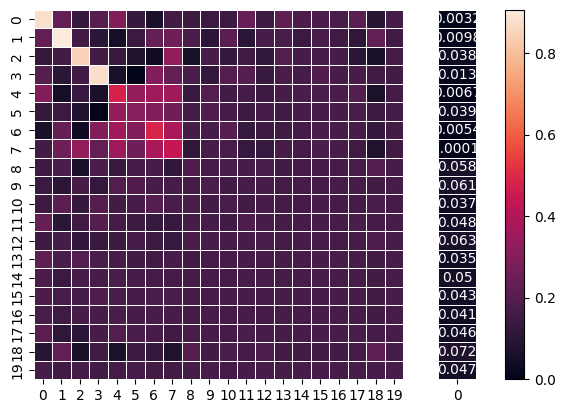

In [109]:
import seaborn as sns

vmin = min(df_W1.values.min(), df_b1.values.min())
vmax = max(df_W1.values.max(), df_b1.values.max())

fig, axs = plt.subplots(ncols=3, gridspec_kw=dict(width_ratios=[10,1,0.5]))

sns.heatmap(df_W1, annot=False, cbar=False, ax=axs[0], vmin=vmin, square=True, linewidth=0.5)
sns.heatmap(df_b1, annot=True, yticklabels=False, cbar=False, ax=axs[1], vmax=vmax, linewidth =0.5)
fig.colorbar(axs[1].collections[0], cax=axs[2])

plt.show()

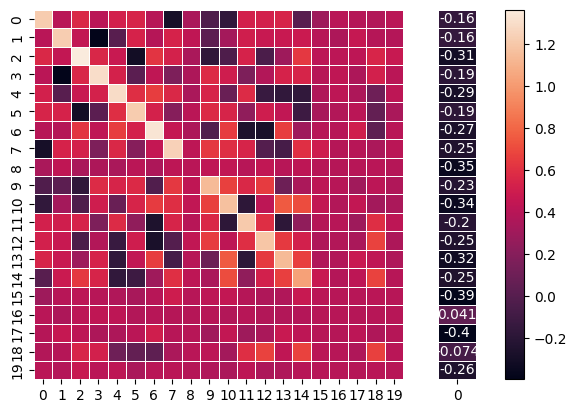

In [110]:
vmin = min(df_W2.values.min(), df_b2.values.min())
vmax = max(df_W2.values.max(), df_b2.values.max())

fig, axs = plt.subplots(ncols=3, gridspec_kw=dict(width_ratios=[10,1,0.5]))

sns.heatmap(df_W2, annot=False, cbar=False, ax=axs[0], vmin=vmin, square=True, linewidth=0.5)
sns.heatmap(df_b2, annot=True, yticklabels=False, cbar=False, ax=axs[1], vmax=vmax, linewidth =0.5)
fig.colorbar(axs[1].collections[0], cax=axs[2])

plt.show()